# WeatherPy

---

In [1]:
# load dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

# citipy will help determine cities based on latitude and longitude data
from citipy import citipy

# import OpenWeatherMap API key
from api_keys import weather_api_key

### Generate the Cities List by Using the `citipy` Library

In [2]:
# instantiate an empty list for holding lat/lng combinations, and one for holding nearest city names
lat_lngs = []
cities = []

# set a range of latitudes and longitudes for random generation
lat_range = (-90, 90)
lng_range = (-180, 180)

# create a set of 1500 random lat/lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)
lat_lngs

In [3]:
# identify the nearest city for each lat/lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # only add new cities to our list
    if city not in cities:
        cities.append(city)

# print the city count
print(f"Number of cities in the list: {len(cities)}")

Number of cities in the list: 598


### Showcase the Relationship Between Weather Attributes and Latitude

In [4]:
# retrieve weather attributes for relevant cities
api_url = 'https://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lng}&appid={API_key}'
city_weather_data = {}

for i, city in enumerate(cities):

    if i % 100 == 0 and i > 1:
        print(f'Working on city #{i}.\n-----\n')

    try:
        response = requests.get(api_url.format(lat=lats[i], lng=lngs[i], API_key=weather_api_key))
        data = response.json()
        
        city_weather_data[city] = {'City' : city,
                                   # 'Country' : data['sys']['country'],
                                   'Latitude' : data['coord']['lat'],
                                   'Longitude': data['coord']['lon'],
                                   'Temperature (Max)' : data['main']['temp_max'],
                                   'Humidity' : data['main']['humidity'],
                                   'Cloudiness' : data['clouds']['all'],
                                   'Wind Speed' : data['wind']['speed']}
        
    except:
        print(f'{city.title()} not found. Moving on.\n-----\n')

print('\nData retrieval complete.\n-----\n')
    


Working on city #100.
-----

Working on city #200.
-----

Working on city #300.
-----

Working on city #400.
-----

Working on city #500.
-----


Data retrieval complete.
-----



In [5]:
# convert the dictionary to a `pandas` data frame and examine data types
city_weather_df = pd.DataFrame.from_dict(city_weather_data, orient='index').reset_index(drop=True)
city_weather_df.dtypes

City                  object
Latitude             float64
Longitude            float64
Temperature (Max)    float64
Humidity               int64
Cloudiness             int64
Wind Speed           float64
dtype: object

In [6]:
# write to csv
city_weather_df.to_csv('output_data/city_weather.csv')
# visualize the the data frame
city_weather_df

,City,Latitude,Longitude,Temperature (Max),Humidity,Cloudiness,Wind Speed
0,comodoro rivadavia,-47.6686,-68.0335,282.05,30,6,5.90
1,lebu,-33.9337,-93.5443,291.91,71,8,5.55
2,illoqqortoormiut,85.6955,-27.8377,246.09,96,37,3.17
3,sitka,50.1235,-136.7123,276.62,97,100,11.54
4,albany,-53.4950,115.5237,276.00,78,100,13.00
...,...,...,...,...,...,...,...
593,tawang,-68.9770,-123.3638,265.71,93,84,4.72
594,lebanon,-34.5370,-71.1383,292.95,50,100,1.82
595,carauari,-70.2726,71.2823,248.99,77,17,9.59
596,gua musang,-72.6518,106.1742,227.40,100,74,5.82


#### Latitude vs. Attribute Scatter Plots

We can use the data from OpenWeatherMap to visulize relationaships between city latitudes and several key weather attributes provided through the API. This should help provide us with some intuition as to how changes in latitude might affect weather patterns.

* Latitude vs. Temperature
* Latitude vs. Humidity
* Latitude vs. Cloudiness
* Latitude vs. Wind Speed

/var/folders/m6/5m5yr4vx1hnfwqqw70nydyqr0000gn/T/ipykernel_37427/3405720068.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


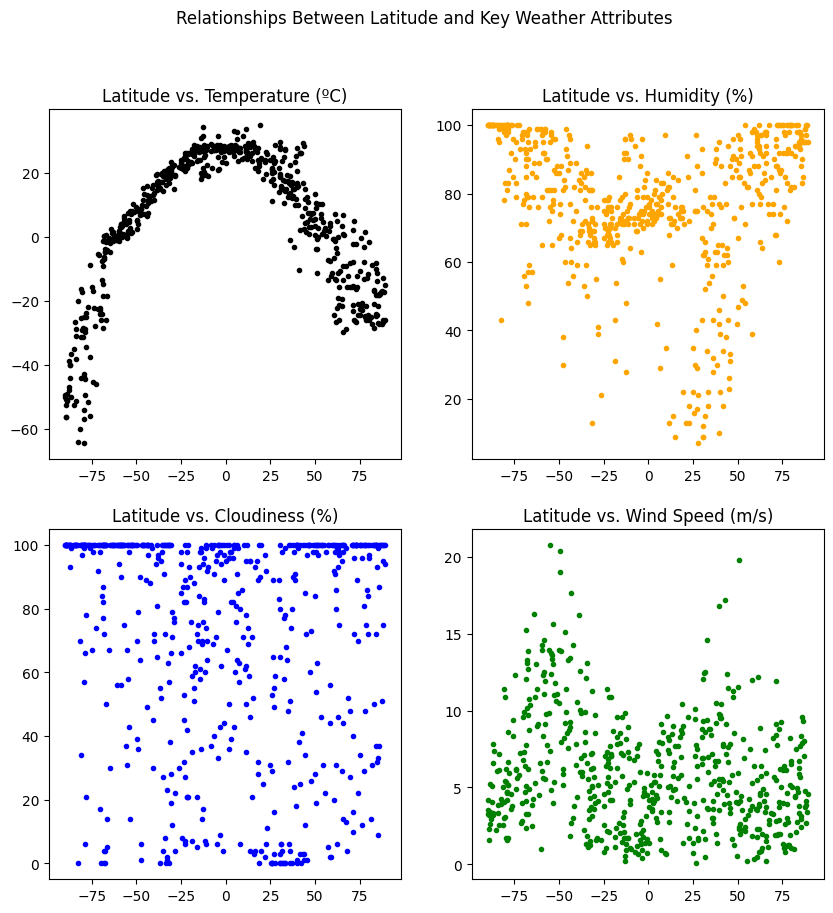

In [7]:
# display a latitude vs. temperature scatter plot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Relationships Between Latitude and Key Weather Attributes')
axs[0, 0].scatter(city_weather_df['Latitude'], city_weather_df['Temperature (Max)'] - 273.15, c='black', marker='.')
axs[0, 0].set_title('Latitude vs. Temperature (ºC)')
axs[0, 1].scatter(city_weather_df['Latitude'], city_weather_df['Humidity'], c='orange', marker='.')
axs[0, 1].set_title('Latitude vs. Humidity (%)')
axs[1, 0].scatter(city_weather_df['Latitude'], city_weather_df['Cloudiness'], c='blue', marker='.')
axs[1, 0].set_title('Latitude vs. Cloudiness (%)')
axs[1, 1].scatter(city_weather_df['Latitude'], city_weather_df['Wind Speed'], c='green', marker='.')
axs[1, 1].set_title('Latitude vs. Wind Speed (m/s)')

# save and display
fig.savefig("output_data/ScatterPlotFigure.png")
fig.show()

### Apply Linear Regression to Each Relationship

In [22]:
# define a function that splits the data into Northern and Southern hemispheres and computes linear regression
def HemiRegress(lat, att):

    # create a dataframe, then split into Northern and Southern hemispheres
    full_df = pd.DataFrame({'Latitude' : lat, 'Attribute' : att})
    northern_df = full_df.loc[full_df['Latitude'] >= 0]
    southern_df = full_df.loc[full_df['Latitude'] < 0]

    # raise an exception if there is a concern about mismatched data subset sizes
    if len(northern_df) + len(southern_df) != len(full_df):
        raise Exception('Uh oh! Something went wrong splitting your data.')
    
    # perform regressions
    northern_reg = linregress(northern_df['Latitude'], northern_df['Attribute'])
    southern_reg = linregress(southern_df['Latitude'], southern_df['Attribute'])

    # create model arrays for plotting northern hemisphere regression
    northern_x = np.linspace(0, 90, 100)
    northern_y = northern_reg[1] * northern_x + northern_reg[0]

    # create model arrays for plotting southern hemisphere regression
    southern_x = np.linspace(-90, 0, 100)
    southern_y = 

    print(northern_x)

    return northern_reg, southern_reg

In [23]:
HemiRegress(city_weather_df['Latitude'], city_weather_df['Temperature (Max)'] - 273.15)

[ 0.          0.90909091  1.81818182  2.72727273  3.63636364  4.54545455
  5.45454545  6.36363636  7.27272727  8.18181818  9.09090909 10.
 10.90909091 11.81818182 12.72727273 13.63636364 14.54545455 15.45454545
 16.36363636 17.27272727 18.18181818 19.09090909 20.         20.90909091
 21.81818182 22.72727273 23.63636364 24.54545455 25.45454545 26.36363636
 27.27272727 28.18181818 29.09090909 30.         30.90909091 31.81818182
 32.72727273 33.63636364 34.54545455 35.45454545 36.36363636 37.27272727
 38.18181818 39.09090909 40.         40.90909091 41.81818182 42.72727273
 43.63636364 44.54545455 45.45454545 46.36363636 47.27272727 48.18181818
 49.09090909 50.         50.90909091 51.81818182 52.72727273 53.63636364
 54.54545455 55.45454545 56.36363636 57.27272727 58.18181818 59.09090909
 60.         60.90909091 61.81818182 62.72727273 63.63636364 64.54545455
 65.45454545 66.36363636 67.27272727 68.18181818 69.09090909 70.
 70.90909091 71.81818182 72.72727273 73.63636364 74.54545455 75.454

(LinregressResult(slope=-0.6656656587614462, intercept=36.274268162452984, rvalue=-0.911031266840465, pvalue=5.601322393998846e-114, stderr=0.017661556517483915, intercept_stderr=0.9324994849977941),
 LinregressResult(slope=0.8529625428370943, intercept=41.756267175705986, rvalue=0.9071279653621641, pvalue=6.531340191816335e-116, stderr=0.022733823672150683, intercept_stderr=1.1810465094702212))